original size of dataset: 12637
center      IMG/center_2016_12_01_13_30_48_287.jpg
left          IMG/left_2016_12_01_13_30_48_287.jpg
right        IMG/right_2016_12_01_13_30_48_287.jpg
steering                                         0
throttle                                         0
brake                                            0
speed                                      22.1483
Name: 0, dtype: object
center      IMG/center_2016_12_01_13_30_48_404.jpg
left          IMG/left_2016_12_01_13_30_48_404.jpg
right        IMG/right_2016_12_01_13_30_48_404.jpg
steering                                         0
throttle                                         0
brake                                            0
speed                                      21.8796
Name: 1, dtype: object
center      IMG/center_2016_12_01_13_31_12_937.jpg
left          IMG/left_2016_12_01_13_31_12_937.jpg
right        IMG/right_2016_12_01_13_31_12_937.jpg
steering                                         0
thro

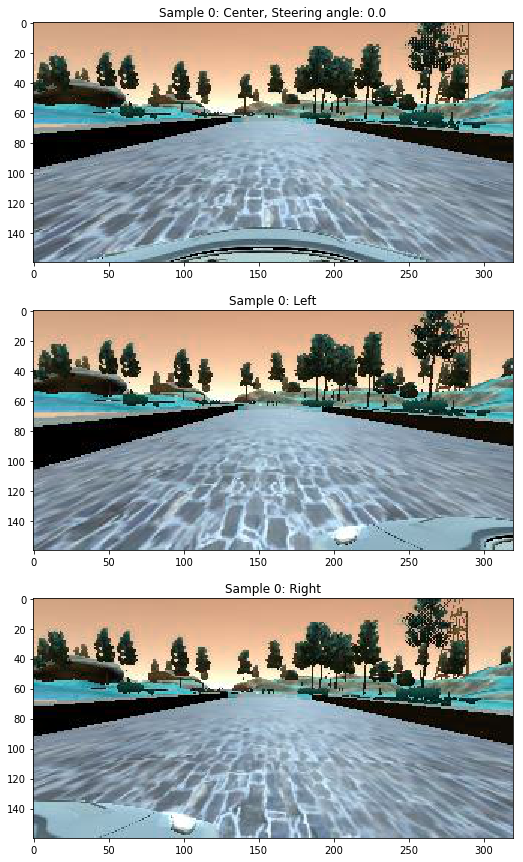

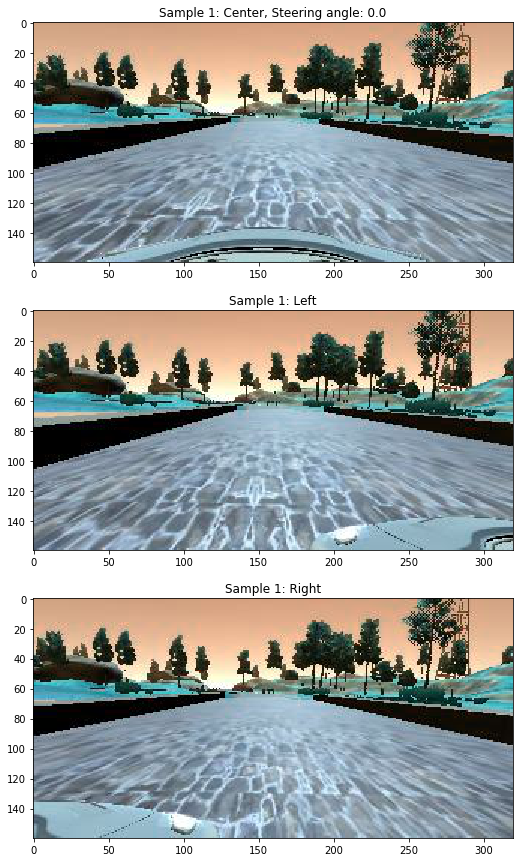

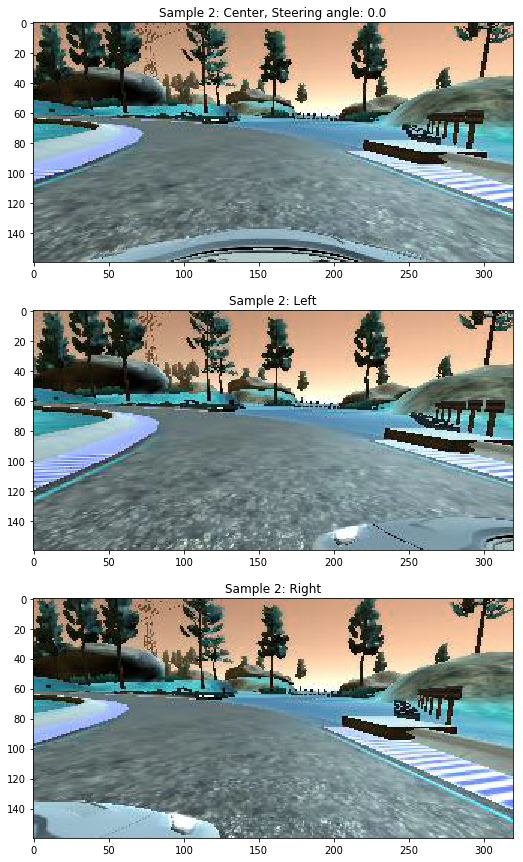

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 
%matplotlib inline

mainDir = '/Users/vijaytramakrishnan/final_report/data/'
black_list_word = '/Users/vijaytramakrishnan/more_data_2/'
steering_angel_shift = 0.2
batch_size = 128

df = pd.read_csv(mainDir + 'driving_log.csv', sep=',', header=0)

## data I obtained by driving around the lap
df2 = pd.read_csv(mainDir + 'driving_log_2.csv', sep=',', header=0)


## combine the two datasets
df = df.append(df2, ignore_index=True)

print("original size of dataset: {}".format(len(df)))

for i in range(0, 3):
    sample_row = df.iloc[i]
    print(sample_row)
    
    index = random.randint(1, len(df))
    
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    a=fig.add_subplot(3,1,1)
    a.set_title('Sample {}: Center, Steering angle: {}'.format(i, sample_row["steering"]))
    img = cv2.imread(mainDir + sample_row["center"].strip(), 1)
    imgplot = plt.imshow(img)

    a=fig.add_subplot(3,1,2)
    a.set_title('Sample {}: Left'.format(i))
    img = cv2.imread(mainDir + sample_row["left"].strip(), 1)
    imgplot = plt.imshow(img)

    a=fig.add_subplot(3,1,3)
    a.set_title('Sample {}: Right'.format(i))
    img = cv2.imread(mainDir + sample_row["right"].strip(), 1)
    imgplot = plt.imshow(img)

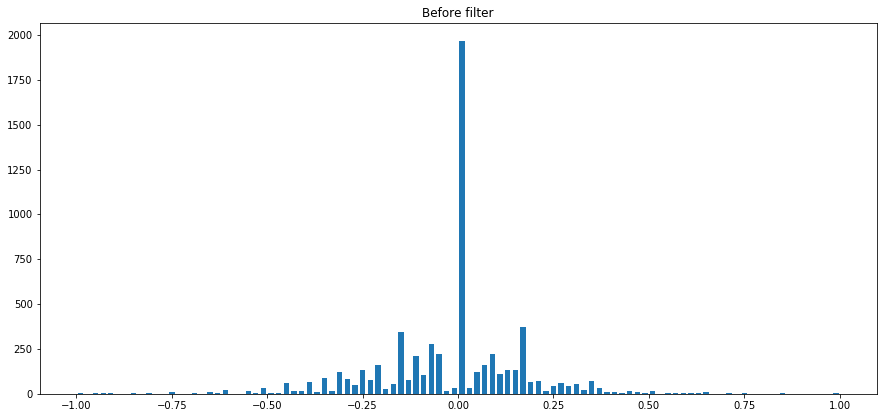

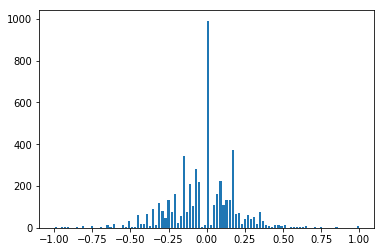

In [61]:
## show the histogram of steering angels
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

a=fig.add_subplot(2,1,1)
a.set_title("Before filter")
hist, bins = np.histogram(np.asarray(df["steering"].tolist()), bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

## remove data with small steering angels
inbet = df[(df["steering"] < 0.05) & (df["steering"] > -0.05)]
out = df[(df["steering"] > 0.05) | (df["steering"] < -0.05)]
df = pd.concat([out, inbet.sample(frac=0.5, replace=False)])

a=fig.add_subplot(2,1,2)
a.set_title("After filter")
hist, bins = np.histogram(np.asarray(df["steering"].tolist()), bins=100)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

train_samples, validation_samples = train_test_split(df, test_size=0.2)

In [ ]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            
            X = batch_samples["center"]
            Left = batch_samples["left"]
            Right = batch_samples["right"]
            
            X_Regular = X.map(lambda img : cv2.imread(mainDir + img.strip().replace(black_list_word, ""), 1))
            Y_Regular = batch_samples["steering"]

            X_Left = Left.map(lambda img : cv2.imread(mainDir + img.strip().replace(black_list_word, ""), 1))
            Y_Left = batch_samples["steering"] + steering_angel_shift

            X_Right = Right.map(lambda img : cv2.imread(mainDir + img.strip().replace(black_list_word, ""), 1))
            Y_Right = batch_samples["steering"] - steering_angel_shift

            X_Reg_flipped = X.map(lambda img : cv2.flip(cv2.imread(mainDir + img.strip().replace(black_list_word, ""), 1), 1))
            Y_Reg_flipped = Y_Regular.map(lambda measurement: -1.0 * measurement)

            X_Left_flipped = Left.map(lambda img : cv2.flip(cv2.imread(mainDir + img.strip().replace(black_list_word, ""), 1), 1))
            Y_Left_flipped = Y_Left.map(lambda measurement: -1.0 * measurement)

            X_Right_flipped = Right.map(lambda img : cv2.flip(cv2.imread(mainDir + img.strip().replace(black_list_word, ""), 1), 1))
            Y_Right_flipped = Y_Right.map(lambda measurement: -1.0 * measurement)

            X_concat = pd.concat([X_Regular, X_Left, X_Right, X_Reg_flipped, X_Left_flipped, X_Right_flipped])
            Y_concat = pd.concat([Y_Regular, Y_Left, Y_Right, Y_Reg_flipped, Y_Left_flipped, Y_Right_flipped])
            X_concat = np.asarray(X_concat.tolist())
            Y_concat = np.asarray(Y_concat.tolist())
                        
            yield shuffle(X_concat, Y_concat)    
    
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

In [3]:
from keras.models import Sequential
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D

dropout = 0.2
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))

model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='relu'))
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation='relu'))

model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile('adam', 'mse')
model.fit_generator(train_generator, 
                    samples_per_epoch=len(train_samples), 
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples), 
                    nb_epoch=7)

Epoch 1/30
6144/6663 [==========================>...] - ETA: 1s - loss: 0.0587

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6912/6663 [===============================] - 22s - loss: 0.0576 - val_loss: 0.0468
Epoch 2/30
6912/6663 [===============================] - 16s - loss: 0.0461 - val_loss: 0.0413
Epoch 3/30
6912/6663 [===============================] - 16s - loss: 0.0337 - val_loss: 0.0317
Epoch 4/30
6912/6663 [===============================] - 16s - loss: 0.0289 - val_loss: 0.0256
Epoch 5/30
6912/6663 [===============================] - 16s - loss: 0.0292 - val_loss: 0.0268
Epoch 6/30
6954/6663 [===============================] - 17s - loss: 0.0273 - val_loss: 0.0204
Epoch 7/30
6912/6663 [===============================] - 16s - loss: 0.0259 - val_loss: 0.0259
Epoch 8/30
6912/6663 [===============================] - 16s - loss: 0.0247 - val_loss: 0.0207
Epoch 9/30
6912/6663 [===============================] - 16s - loss: 0.0249 - val_loss: 0.0243
Epoch 10/30
6912/6663 [===============================] - 16s - loss: 0.0262 - val_loss: 0.0256
Epoch 11/30
6912/6663 [===============================] - 16

In [4]:
from keras.models import load_model
model.save('model.h5') 

In [ ]:
### extra functions

import csv

with open(secondaryDir + 'driving_log.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]
    
with open(secondaryDir + 'driving_log.csv','w',newline='') as f:
    w = csv.writer(f)
    w.writerow(["center","left","right","steering","throttle","brake","speed"])
    w.writerows(data)